# Case 2: User KGI 04

## Import Dependencies

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, make_scorer, r2_score
from sklearn.model_selection import KFold, cross_val_score
from sklearn.neural_network import MLPRegressor
import xgboost as xgb
import optuna
from optuna.samplers import TPESampler
import joblib
from sklearn.pipeline import Pipeline

## Data Loading

In [2]:
DATA_PATH = "./Dataset/"
CSV_FILES = ["15_9-F-1 A.csv", "15_9-F-1 B.csv", "15_9-F-1 C.csv", "15_9-F-11 A.csv", "15_9-F-11 B.csv"]

def load_data(file_paths):
    all_data = []
    
    for file_path in file_paths:
        try:
            full_path = os.path.join(DATA_PATH, file_path)
            df = pd.read_csv(full_path)
            
            well_name = os.path.basename(file_path).split('.')[0]
            df['WELL'] = well_name
            
            all_data.append(df)
            print(f"Loaded {file_path} successfully")
        except FileNotFoundError:
            print(f"Warning: File {file_path} not found. Skipping.")
        except Exception as e:
            print(f"Error loading {file_path}: {str(e)}")
    
    combined_df = pd.concat(all_data, ignore_index=True)
    print(f"Combined dataset shape: {combined_df.shape}")
    return combined_df

file_paths = [os.path.join(DATA_PATH, file) for file in CSV_FILES]
df = load_data(CSV_FILES)

Loaded 15_9-F-1 A.csv successfully
Loaded 15_9-F-1 B.csv successfully
Loaded 15_9-F-1 C.csv successfully
Loaded 15_9-F-11 A.csv successfully
Loaded 15_9-F-11 B.csv successfully
Combined dataset shape: (33673, 9)


## Simple Data Exploration

In [3]:
print("\n--- Data Exploration ---")
print(f"Dataset Shape: {df.shape}")
print("First 5 rows:")
print(df.head())

print("\nBasic Statistics:")
print(df.describe())

print("\nMissing Values:")
missing_values = df.isnull().sum()
print(missing_values)
print(f"\nMissing Values Percentage:")
print((missing_values / len(df)) * 100)


--- Data Exploration ---
Dataset Shape: (33673, 9)
First 5 rows:
    DEPTH    NPHI    RHOB      GR       RT     PEF    CALI       DT  \
0  3100.0  0.0481  2.6067  8.3222  10.1810  7.5681  8.5781  60.6463   
1  3100.1  0.0481  2.6061  8.5168  10.0395  7.5860  8.5781  60.6713   
2  3100.2  0.0483  2.6063  8.3134   9.9846  7.6333  8.5781  60.7070   
3  3100.3  0.0486  2.6078  8.6389   9.9122  7.6751  8.5781  60.7455   
4  3100.4  0.0488  2.6091  8.2602   9.8524  7.6777  8.5781  60.7840   

         WELL  
0  15_9-F-1 A  
1  15_9-F-1 A  
2  15_9-F-1 A  
3  15_9-F-1 A  
4  15_9-F-1 A  

Basic Statistics:
              DEPTH          NPHI          RHOB            GR            RT  \
count  33673.000000  22814.000000  22870.000000  33489.000000  33209.000000   
mean    3225.772028      0.183379      2.461276     41.988215    429.736408   
std      287.753501      0.084425      0.148896     50.460093   5097.033177   
min     2600.000000      0.042000      2.033000      0.969100      0.065000 

## Basic Data Visualization


--- Data Visualization ---
Creating visualizations...


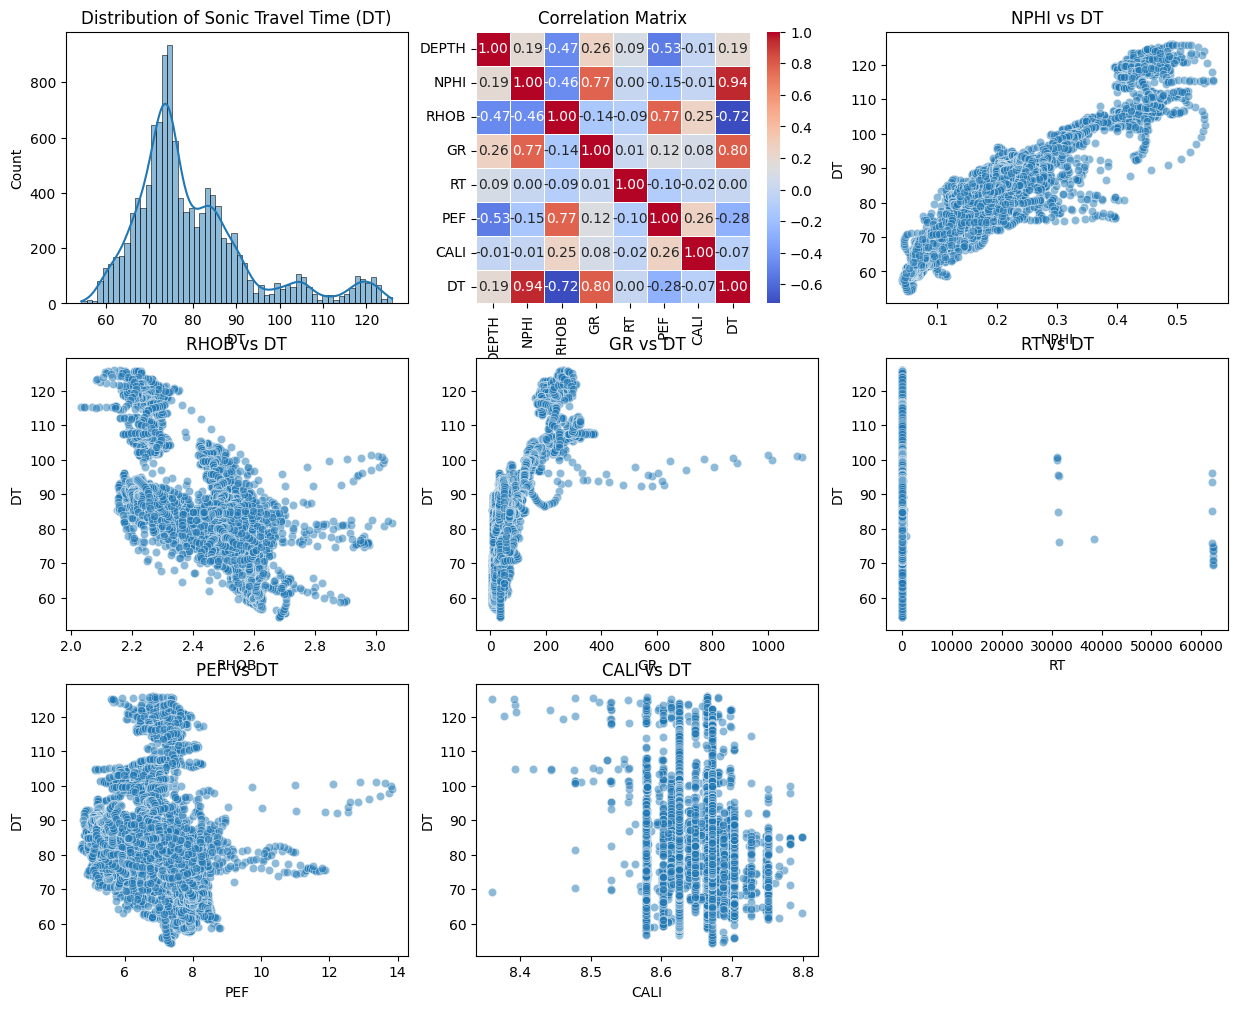

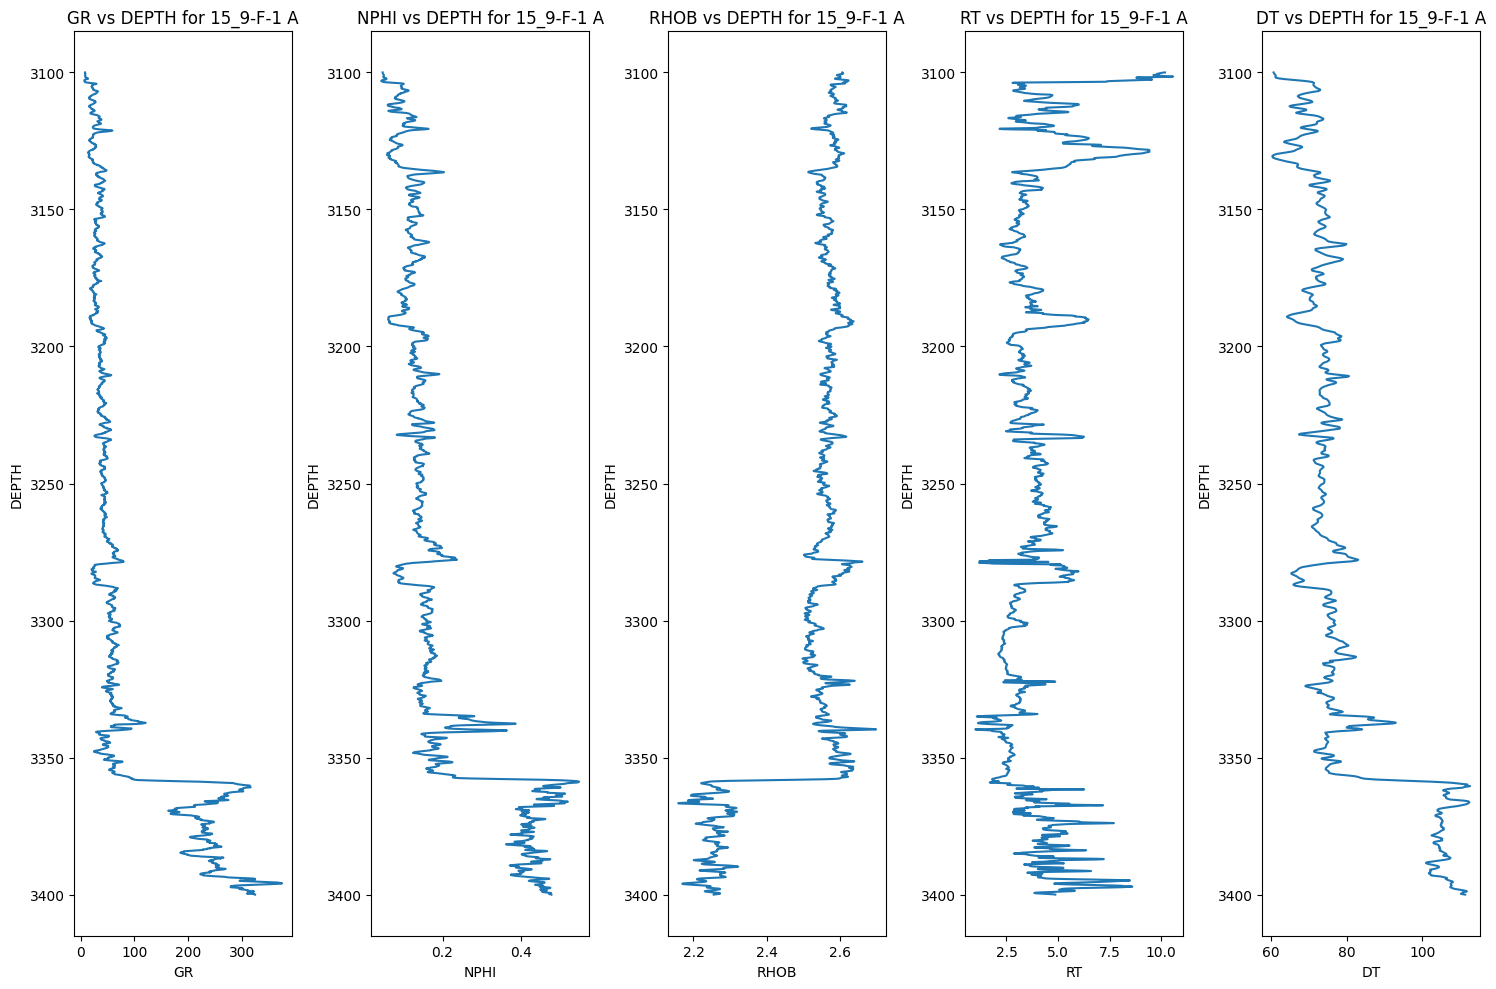

In [4]:
print("\n--- Data Visualization ---")
print("Creating visualizations...")

plt.figure(figsize=(15, 12))

plt.subplot(3, 3, 1)
sns.histplot(df['DT'].dropna(), kde=True)
plt.title('Distribution of Sonic Travel Time (DT)')

plt.subplot(3, 3, 2)
numeric_cols = df.select_dtypes(include=[np.number]).columns
corr_matrix = df[numeric_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')

features = ['NPHI', 'RHOB', 'GR', 'RT', 'PEF', 'CALI']
plot_pos = 3

for feature in features:
    plt.subplot(3, 3, plot_pos)
    sns.scatterplot(x=feature, y='DT', data=df, alpha=0.5)
    plt.title(f'{feature} vs DT')
    plot_pos += 1

if 'WELL' in df.columns:
    well_name = df['WELL'].unique()[0]
    well_data = df[df['WELL'] == well_name].copy()
    
    plt.figure(figsize=(15, 10))

    logs_to_plot = ['GR', 'NPHI', 'RHOB', 'RT', 'DT']
    num_logs = len(logs_to_plot)
    
    for i, log in enumerate(logs_to_plot):
        plt.subplot(1, num_logs, i+1)
        plt.plot(well_data[log], well_data['DEPTH'])
        plt.xlabel(log)
        plt.ylabel('DEPTH')
        plt.gca().invert_yaxis()
        plt.title(f'{log} vs DEPTH for {well_name}')
    
    plt.tight_layout()
    plt.savefig('depth_logs_plot.png')

plt.tight_layout()
plt.savefig('exploratory_analysis.png')

## Data Preprocessing

### Data Imputation

In [5]:
print("\nApplying domain-specific imputation strategies...")

wells = df['WELL'].unique()
processed_dfs = []

for well in wells:
    print(f"Processing well: {well}")
    well_data = df[df['WELL'] == well].copy()
    
    well_data = well_data.sort_values('DEPTH')
    
    dense_logs = ['GR', 'RT']
    for log in dense_logs:
        if log in well_data.columns:
            well_data[log] = well_data[log].interpolate(method='cubic', limit_direction='both')
    
    sparse_logs = ['NPHI', 'RHOB', 'PEF', 'CALI']
    for log in sparse_logs:
        if log in well_data.columns:
            well_data[log] = well_data[log].interpolate(method='linear', limit_direction='both')
    
    if 'DT' in well_data.columns:
        missing_dt_mask = well_data['DT'].isnull()
        missing_dt_count = missing_dt_mask.sum()
        
        if missing_dt_count > 0:
            print(f"  Imputing {missing_dt_count} missing DT values using physics-based relationships")
            
            complete_data = well_data.dropna(subset=['DT', 'RHOB', 'NPHI', 'GR']).copy()
            
            if len(complete_data) >= 10:
                
                features = ['RHOB', 'NPHI', 'GR', 'RT']
                available_features = [f for f in features if f in complete_data.columns and complete_data[f].isnull().sum() == 0]
                
                if len(available_features) >= 2:  
                    X_mini = complete_data[available_features]
                    y_mini = complete_data['DT']
                    
                    mini_model = RandomForestRegressor(n_estimators=50, random_state=42)
                    mini_model.fit(X_mini, y_mini)
                    
                    missing_dt_rows = well_data[missing_dt_mask].copy()
                    valid_prediction_mask = ~missing_dt_rows[available_features].isnull().any(axis=1)
                    
                    if valid_prediction_mask.sum() > 0:
                        X_predict = missing_dt_rows.loc[valid_prediction_mask, available_features]
                        predictions = mini_model.predict(X_predict)
                        

                        well_data.loc[missing_dt_mask & valid_prediction_mask, 'DT'] = predictions
                        print(f"    Successfully predicted {len(predictions)} DT values using RandomForest")

            well_data['DT'] = well_data['DT'].interpolate(method='linear', limit_direction='both')
    
    processed_dfs.append(well_data)

df = pd.concat(processed_dfs, ignore_index=True)

print("\nApplying KNN imputation for remaining missing values...")
remaining_nulls = df.select_dtypes(include=[np.number]).isnull().sum()
columns_with_nulls = remaining_nulls[remaining_nulls > 0].index.tolist()

if columns_with_nulls:
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    
    if 'WELL' in numeric_cols:
        numeric_cols.remove('WELL')
    
    impute_df = df[numeric_cols].copy()
    
    knn_imputer = KNNImputer(n_neighbors=5, weights='distance')
    imputed_values = knn_imputer.fit_transform(impute_df)
    
    df[numeric_cols] = imputed_values
    
    print("KNN imputation completed")

final_nulls = df.isnull().sum()
print("\nRemaining missing values after all imputation steps:")
print(final_nulls[final_nulls > 0])

if final_nulls.sum() > 0:
    df = df.fillna(df.mean())
    print("All missing values have been handled")

print(f"Final dataset contains {len(df)} rows")


Applying domain-specific imputation strategies...
Processing well: 15_9-F-1 A
Processing well: 15_9-F-1 B
  Imputing 403 missing DT values using physics-based relationships
    Successfully predicted 314 DT values using RandomForest
Processing well: 15_9-F-1 C
  Imputing 11201 missing DT values using physics-based relationships
Processing well: 15_9-F-11 A
  Imputing 386 missing DT values using physics-based relationships
    Successfully predicted 280 DT values using RandomForest
Processing well: 15_9-F-11 B
  Imputing 10201 missing DT values using physics-based relationships

Applying KNN imputation for remaining missing values...
KNN imputation completed

Remaining missing values after all imputation steps:
Series([], dtype: int64)
Final dataset contains 33673 rows


### Outlier Handling

In [6]:
def detect_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

for column in df.select_dtypes(include=[np.number]).columns:
    if column not in ['DEPTH', 'WELL']:
        outliers, lb, ub = detect_outliers(df, column)
        print(f"Outliers in {column}: {len(outliers)}, Range: ({lb:.2f}, {ub:.2f})")

def handle_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[column] = np.where(df[column] < lower_bound, lower_bound, df[column])
    df[column] = np.where(df[column] > upper_bound, upper_bound, df[column])
    return df

for column in df.select_dtypes(include=[np.number]).columns:
    if column not in ['DEPTH', 'WELL']:
        df = handle_outliers(df, column)

print("Outliers handled using capping method")

Outliers in NPHI: 1268, Range: (-0.05, 0.35)
Outliers in RHOB: 2175, Range: (2.22, 2.83)
Outliers in GR: 1749, Range: (-40.83, 105.19)
Outliers in RT: 2859, Range: (-3.27, 10.47)
Outliers in PEF: 105, Range: (4.02, 9.95)
Outliers in CALI: 283, Range: (8.44, 8.81)
Outliers in DT: 1090, Range: (45.08, 102.85)
Outliers handled using capping method


### Feature Engineering

In [7]:
print("\nPerforming feature engineering...")
df['NPHI_RHOB'] = df['NPHI'] * df['RHOB']
df['GR_NPHI'] = df['GR'] * df['NPHI']
df['PEF_RHOB'] = df['PEF'] * df['RHOB']
df['RT_LOG'] = np.log10(df['RT'])

print("Engineered features added to dataset")

features_to_exclude = ['DT', 'DEPTH']
if 'WELL' in df.columns:
    features_to_exclude.append('WELL')
X = df.drop(columns=features_to_exclude)
y = df['DT']

print(f"Features: {X.columns.tolist()}")


Performing feature engineering...
Engineered features added to dataset
Features: ['NPHI', 'RHOB', 'GR', 'RT', 'PEF', 'CALI', 'NPHI_RHOB', 'GR_NPHI', 'PEF_RHOB', 'RT_LOG']


### Data Split

In [8]:
print("Splitting data into training and testing sets...")
if 'WELL' in df.columns and len(df['WELL'].unique()) > 1:
    wells = df['WELL'].unique()
    
    train_wells = wells[:-1]
    test_wells = wells[-1:]
    
    print(f"Training on wells: {train_wells.tolist()}")
    print(f"Testing on wells: {test_wells.tolist()}")
    
    # Create the train and test sets
    train_mask = df['WELL'].isin(train_wells)
    X_train = X[train_mask]
    y_train = y[train_mask]
    X_test = X[~train_mask]
    y_test = y[~train_mask]
else:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Train set: {X_train.shape}, Test set: {X_test.shape}")

Splitting data into training and testing sets...
Training on wells: ['15_9-F-1 A', '15_9-F-1 B', '15_9-F-1 C', '15_9-F-11 A']
Testing on wells: ['15_9-F-11 B']
Train set: (23472, 10), Test set: (10201, 10)


### Data Standarization

In [9]:
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

## Model Building and Training

In [10]:
print("\n--- Model Building and Training ---")

def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    model.fit(X_train, y_train)
    
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    
    print(f"\n{model_name} Performance:")
    print(f"Train RMSE: {train_rmse:.2f}")
    print(f"Test RMSE: {test_rmse:.2f}")
    print(f"Train R²: {train_r2:.2f}")
    print(f"Test R²: {test_r2:.2f}")
    print(f"Train MAE: {train_mae:.2f}")
    print(f"Test MAE: {test_mae:.2f}")

    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    # cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='r2')
    # print(f"Cross-Validation R² Scores: {cv_scores}")
    # print(f"Mean CV R²: {cv_scores.mean():.2f}")
    
    cv_r2 = cross_val_score(model, X, y, cv=cv, scoring='r2')
    cv_mae = cross_val_score(model, X, y, cv=cv, scoring='neg_mean_absolute_error')
    cv_rmse = cross_val_score(model, X, y, cv=cv, scoring=make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)), greater_is_better=False))

    print(f"Cross-Validation R² Scores: {cv_r2}")
    print(f"Mean CV R²: {cv_r2.mean():.2f}")
    print(f"Mean CV MAE: {-cv_mae.mean():.2f}")
    print(f"Mean CV RMSE: {-cv_rmse.mean():.2f}")

    return model, y_test_pred, test_rmse, test_r2, test_mae

model_performances = {}

lr_model = LinearRegression()
lr_model, lr_pred, lr_rmse, lr_r2, lr_mae = evaluate_model(
    lr_model, X_train_scaled, X_test_scaled, y_train, y_test, "Linear Regression"
)
model_performances['Linear Regression'] = {'RMSE': lr_rmse, 'R²': lr_r2, 'MAE': lr_mae, 'predictions': lr_pred}

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model, rf_pred, rf_rmse, rf_r2, rf_mae = evaluate_model(
    rf_model, X_train_scaled, X_test_scaled, y_train, y_test, "Random Forest"
)
model_performances['Random Forest'] = {'RMSE': rf_rmse, 'R²': rf_r2, 'MAE': rf_mae, 'predictions': rf_pred}

xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model, xgb_pred, xgb_rmse, xgb_r2, xgb_mae = evaluate_model(
    xgb_model, X_train_scaled, X_test_scaled, y_train, y_test, "XGBoost"
)
model_performances['XGBoost'] = {'RMSE': xgb_rmse, 'R²': xgb_r2, 'MAE': xgb_mae, 'predictions': xgb_pred}

nn_model = MLPRegressor(hidden_layer_sizes=(64, 32), activation='relu', max_iter=1000, random_state=42)
nn_model, nn_pred, nn_rmse, nn_r2, nn_mae = evaluate_model(
    nn_model, X_train_scaled, X_test_scaled, y_train, y_test, "Neural Network"
)
model_performances['Neural Network'] = {'RMSE': nn_rmse, 'R²': nn_r2, 'MAE': nn_mae, 'predictions': nn_pred}

best_model_name = min(model_performances, key=lambda k: model_performances[k]['RMSE'])
print(f"\nBest model based on Test RMSE: {best_model_name}")
print(f"Test RMSE: {model_performances[best_model_name]['RMSE']:.2f}")
print(f"Test R²: {model_performances[best_model_name]['R²']:.2f}")
print(f"Test MAE: {model_performances[best_model_name]['MAE']:.2f}")


--- Model Building and Training ---

Linear Regression Performance:
Train RMSE: 4.82
Test RMSE: 5.37
Train R²: 0.79
Test R²: 0.57
Train MAE: 3.72
Test MAE: 4.13
Cross-Validation R² Scores: [0.7796972  0.7698019  0.77631452 0.76479477 0.76984025]
Mean CV R²: 0.77
Mean CV MAE: 3.74
Mean CV RMSE: 4.90

Random Forest Performance:
Train RMSE: 0.67
Test RMSE: 5.20
Train R²: 1.00
Test R²: 0.60
Train MAE: 0.36
Test MAE: 3.94
Cross-Validation R² Scores: [0.95866676 0.95741768 0.96194667 0.95710509 0.95370802]
Mean CV R²: 0.96
Mean CV MAE: 1.16
Mean CV RMSE: 2.11

XGBoost Performance:
Train RMSE: 1.95
Test RMSE: 5.14
Train R²: 0.97
Test R²: 0.61
Train MAE: 1.28
Test MAE: 4.00
Cross-Validation R² Scores: [0.93640342 0.93597016 0.93930893 0.93327027 0.93135139]
Mean CV R²: 0.94
Mean CV MAE: 1.68
Mean CV RMSE: 2.61

Neural Network Performance:
Train RMSE: 2.60
Test RMSE: 6.12
Train R²: 0.94
Test R²: 0.44
Train MAE: 1.71
Test MAE: 5.07
Cross-Validation R² Scores: [0.85564983 0.86468962 0.86808741 0

## Hyperparameter Tuning with Bayesian Optimization

[I 2025-04-25 10:22:27,676] A new study created in memory with name: no-name-1b8abe77-73cc-4cfa-8648-acf0026b2220



--- Hyperparameter Tuning with Optuna ---
Tuning XGBoost model with Optuna...


[I 2025-04-25 10:23:12,634] Trial 0 finished with value: 4.876236843930702 and parameters: {'learning_rate': 0.03574712922600244, 'n_estimators': 478, 'max_depth': 10, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'min_child_weight': 2, 'gamma': 0.05808361216819946}. Best is trial 0 with value: 4.876236843930702.
[I 2025-04-25 10:23:32,140] Trial 1 finished with value: 5.076706909695323 and parameters: {'learning_rate': 0.19030368381735815, 'n_estimators': 321, 'max_depth': 10, 'subsample': 0.608233797718321, 'colsample_bytree': 0.9879639408647978, 'min_child_weight': 9, 'gamma': 0.21233911067827616}. Best is trial 0 with value: 4.876236843930702.
[I 2025-04-25 10:23:35,394] Trial 2 finished with value: 4.968653118238545 and parameters: {'learning_rate': 0.01855998084649059, 'n_estimators': 132, 'max_depth': 6, 'subsample': 0.8099025726528951, 'colsample_bytree': 0.7727780074568463, 'min_child_weight': 3, 'gamma': 0.6118528947223795}. Best is trial 0 with val

Best trial:
  Value (RMSE): 4.8008
  Params: {'learning_rate': 0.010844223246251797, 'n_estimators': 404, 'max_depth': 12, 'subsample': 0.8691688544175845, 'colsample_bytree': 0.6908016164261375, 'min_child_weight': 7, 'gamma': 0.6854344815393383}


C:\Users\Vissuta Gunawan Lim\AppData\Local\Temp\ipykernel_20640\1179015231.py:177: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_param_importances(study)


Tuned Model RMSE on Test Set: 4.9930
Tuned Model R² on Test Set: 0.6302
Tuned Model MAE on Test Set: 3.8736


<Figure size 1000x600 with 0 Axes>

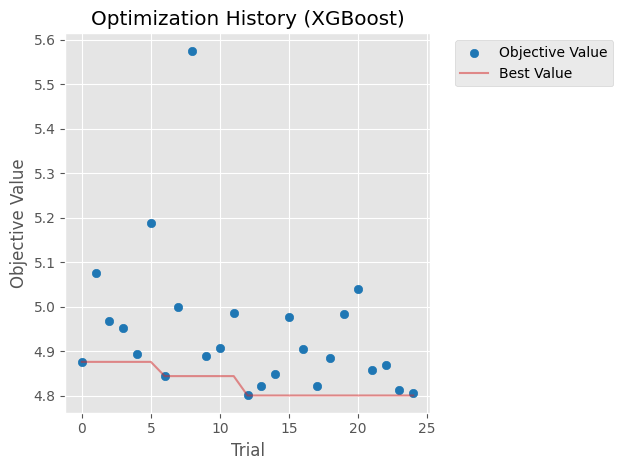

<Figure size 1500x600 with 0 Axes>

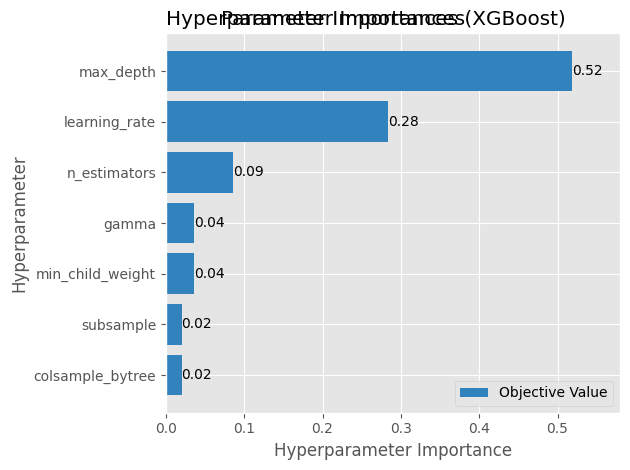

In [15]:
print("\n--- Hyperparameter Tuning with Optuna ---")


def objective_rf(trial):
    """Objective function for Random Forest optimization"""
    
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    max_depth = trial.suggest_int('max_depth', 5, 30, log=True)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
    
   
    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=42
    )
    
   
    cv_scores = cross_val_score(
        model, X_train_scaled, y_train, 
        cv=5, scoring='neg_mean_squared_error'
    )
    rmse = np.sqrt(-cv_scores.mean())
    
    return rmse

def objective_xgb(trial):
    """Objective function for XGBoost optimization"""
   
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3, log=True)
    n_estimators = trial.suggest_int('n_estimators', 50, 500)
    max_depth = trial.suggest_int('max_depth', 3, 12)
    subsample = trial.suggest_float('subsample', 0.6, 1.0)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.6, 1.0)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 10)
    gamma = trial.suggest_float('gamma', 0.0, 1.0)
    
    
    model = xgb.XGBRegressor(
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        max_depth=max_depth,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        min_child_weight=min_child_weight,
        gamma=gamma,
        random_state=42
    )
    
   
    cv_scores = cross_val_score(
        model, X_train_scaled, y_train, 
        cv=5, scoring='neg_mean_squared_error'
    )
    rmse = np.sqrt(-cv_scores.mean())
    
    return rmse

def objective_nn(trial):
    """Objective function for Neural Network optimization"""
    
    n_layers = trial.suggest_int('n_layers', 1, 3)
    layers = []
    for i in range(n_layers):
        layers.append(trial.suggest_int(f'n_units_l{i}', 16, 256, log=True))
    
    
    activation = trial.suggest_categorical('activation', ['relu', 'tanh'])
    alpha = trial.suggest_float('alpha', 1e-5, 1e-2, log=True)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-1, log=True)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64, 128])
    
    
    model = MLPRegressor(
        hidden_layer_sizes=tuple(layers),
        activation=activation,
        alpha=alpha,
        learning_rate_init=learning_rate,
        batch_size=batch_size,
        max_iter=1000,
        random_state=42
    )
    
   
    cv_scores = cross_val_score(
        model, X_train_scaled, y_train, 
        cv=5, scoring='neg_mean_squared_error'
    )
    rmse = np.sqrt(-cv_scores.mean())
    
    return rmse


if best_model_name == 'Random Forest':
    print("Tuning Random Forest model with Optuna...")
    study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=42))
    study.optimize(objective_rf, n_trials=25)
    
    print(f"Best trial:")
    print(f"  Value (RMSE): {study.best_value:.4f}")
    print(f"  Params: {study.best_params}")
    
    
    best_model = RandomForestRegressor(
        n_estimators=study.best_params['n_estimators'],
        max_depth=study.best_params['max_depth'],
        min_samples_split=study.best_params['min_samples_split'],
        min_samples_leaf=study.best_params['min_samples_leaf'],
        max_features=study.best_params['max_features'],
        random_state=42
    )
    
elif best_model_name == 'XGBoost':
    print("Tuning XGBoost model with Optuna...")
    study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=42))
    study.optimize(objective_xgb, n_trials=25)
    
    print(f"Best trial:")
    print(f"  Value (RMSE): {study.best_value:.4f}")
    print(f"  Params: {study.best_params}")
    
   
    best_model = xgb.XGBRegressor(
        learning_rate=study.best_params['learning_rate'],
        n_estimators=study.best_params['n_estimators'],
        max_depth=study.best_params['max_depth'],
        subsample=study.best_params['subsample'],
        colsample_bytree=study.best_params['colsample_bytree'],
        min_child_weight=study.best_params['min_child_weight'],
        gamma=study.best_params['gamma'],
        random_state=42
    )
    
elif best_model_name == 'Neural Network':
    print("Tuning Neural Network model with Optuna...")
    study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=42))
    study.optimize(objective_nn, n_trials=25)
    
    print(f"Best trial:")
    print(f"  Value (RMSE): {study.best_value:.4f}")
    print(f"  Params: {study.best_params}")
    
    
    n_layers = study.best_params['n_layers']
    layers = []
    for i in range(n_layers):
        layers.append(study.best_params[f'n_units_l{i}'])
    
    
    best_model = MLPRegressor(
        hidden_layer_sizes=tuple(layers),
        activation=study.best_params['activation'],
        alpha=study.best_params['alpha'],
        learning_rate_init=study.best_params['learning_rate'],
        batch_size=study.best_params['batch_size'],
        max_iter=1000,
        random_state=42
    )
    
else:  
    best_model = lr_model


if best_model_name != 'Linear Regression':
    plt.figure(figsize=(10, 6))
    optuna.visualization.matplotlib.plot_optimization_history(study)
    plt.title(f'Optimization History ({best_model_name})')
    plt.tight_layout()
    plt.savefig('optuna_optimization_history.png')
    
    plt.figure(figsize=(15, 6))
    optuna.visualization.matplotlib.plot_param_importances(study)
    plt.title(f'Parameter Importances ({best_model_name})')
    plt.tight_layout()
    plt.savefig('optuna_param_importances.png')

best_model.fit(X_train_scaled, y_train)
best_predictions = best_model.predict(X_test_scaled)
best_rmse = np.sqrt(mean_squared_error(y_test, best_predictions))
best_r2 = r2_score(y_test, best_predictions)
best_mae = mean_absolute_error(y_test, best_predictions)

print(f"Tuned Model RMSE on Test Set: {best_rmse:.4f}")
print(f"Tuned Model R² on Test Set: {best_r2:.4f}")
print(f"Tuned Model MAE on Test Set: {best_mae:.4f}")

## Model Evaluation Visualization


--- Model Evaluation and Visualization ---
Model predictions visualized and saved as 'model_predictions.png'
DT log prediction visualized and saved as 'dt_prediction_log.png'


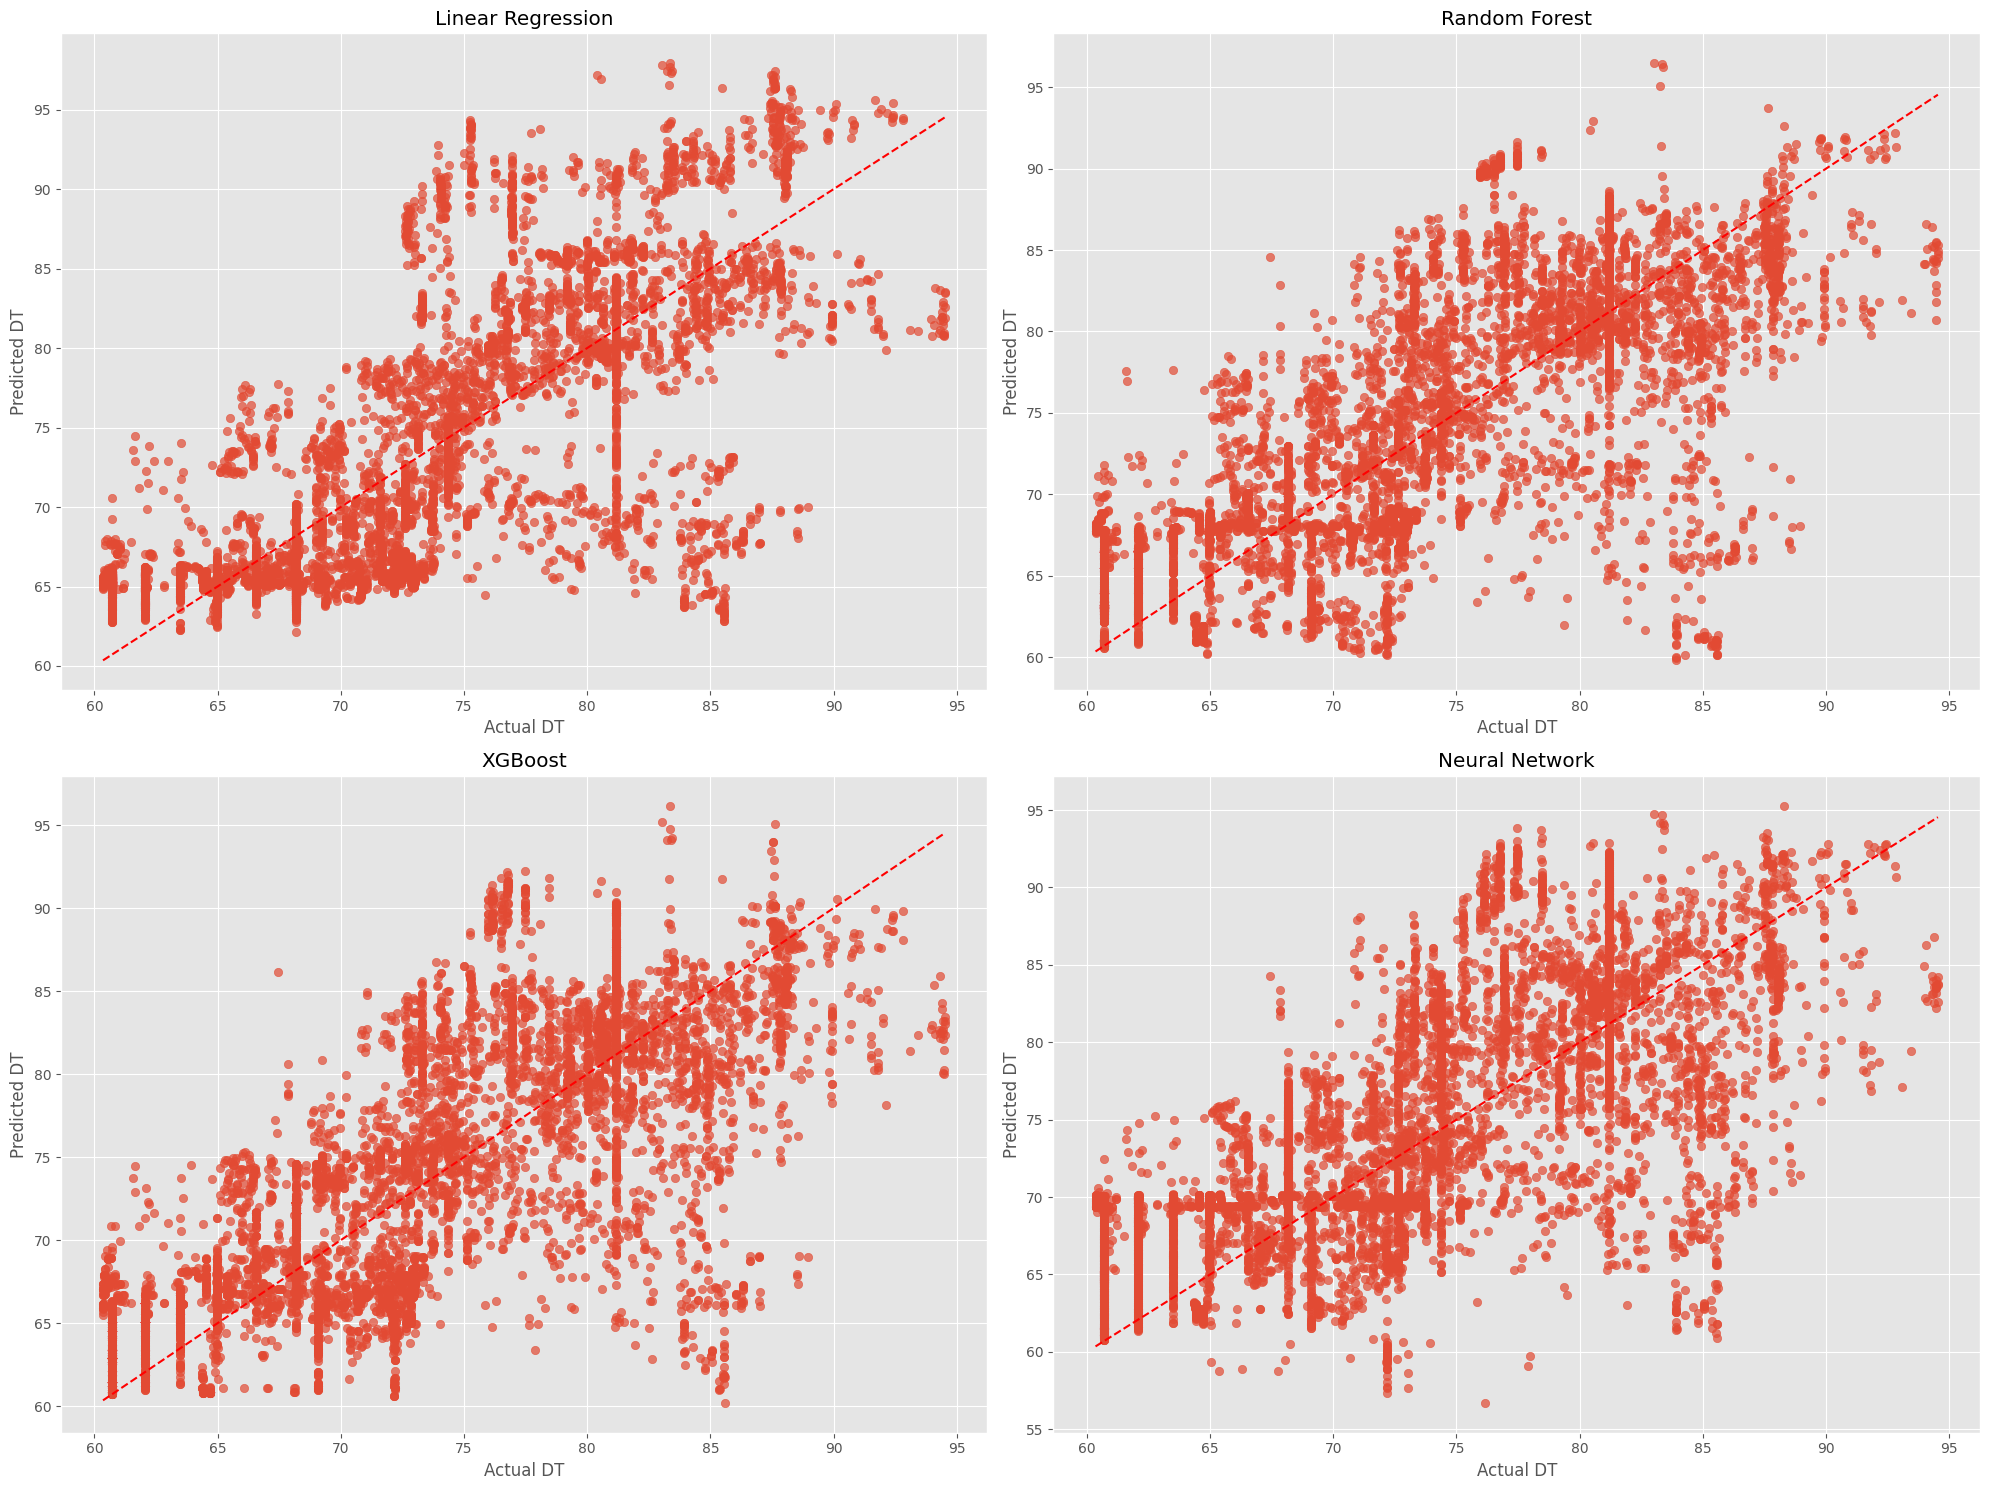

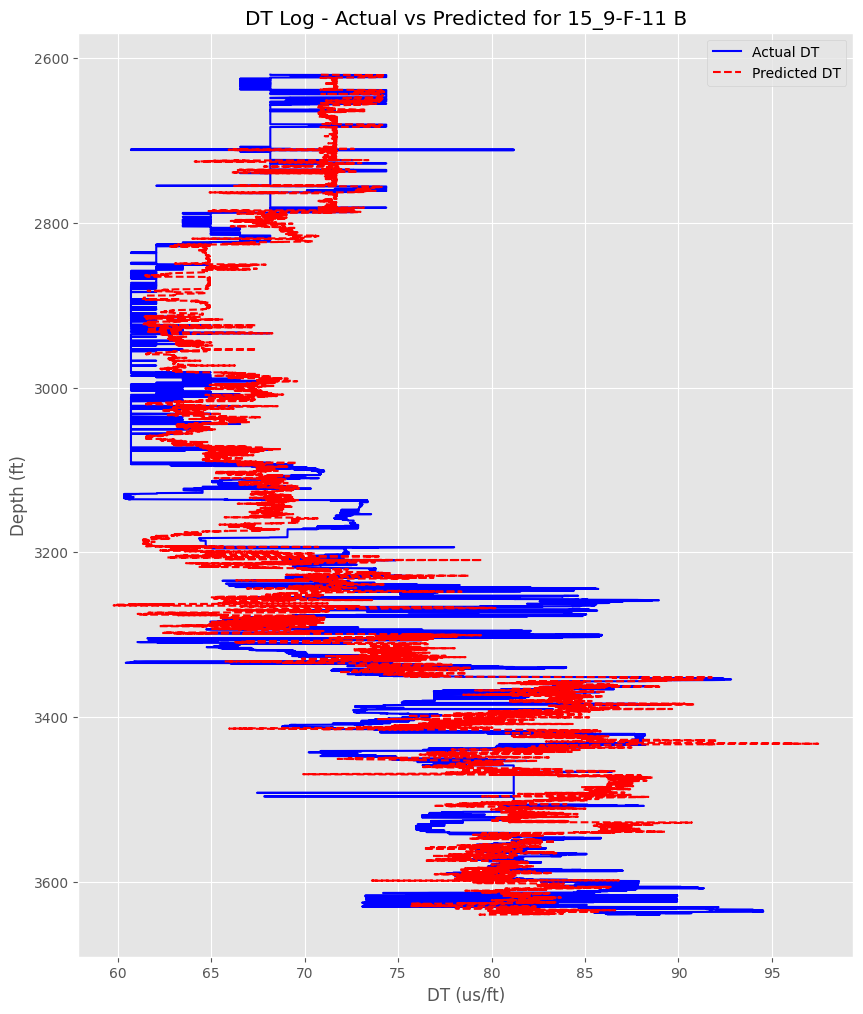

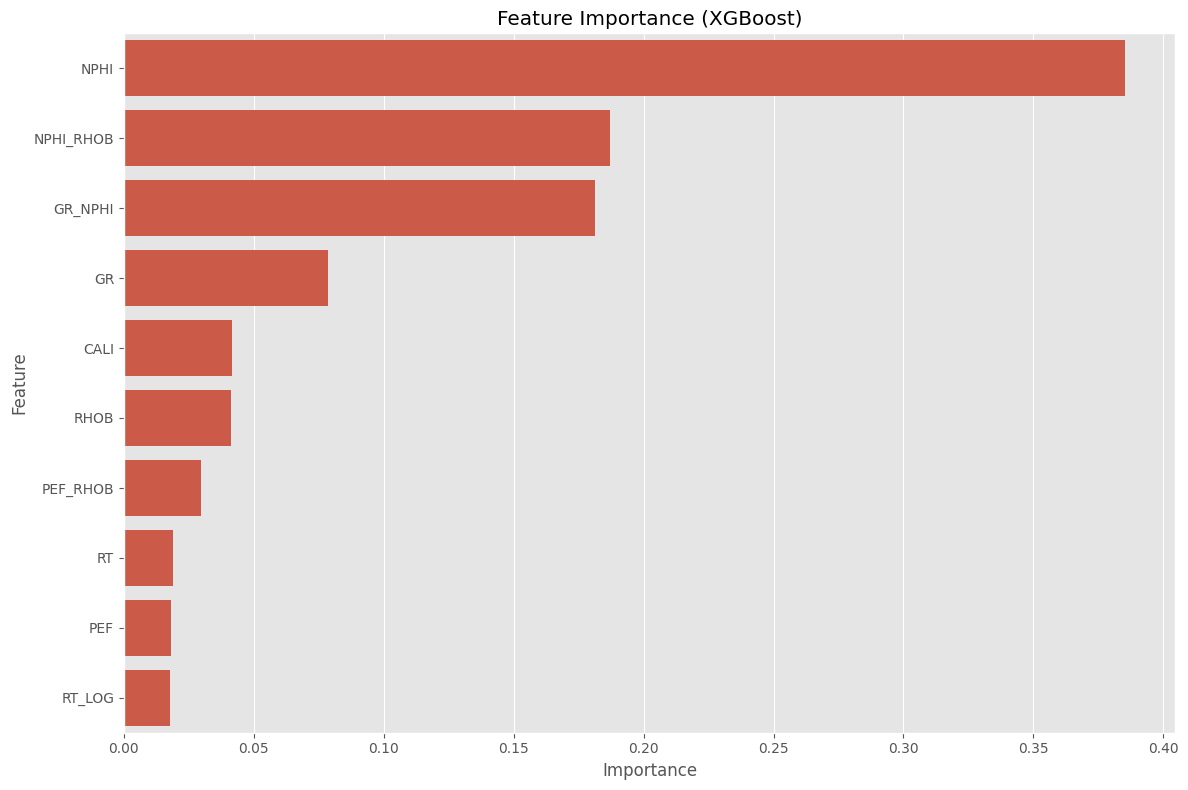

In [ ]:
print("\n--- Model Evaluation and Visualization ---")

plt.figure(figsize=(20, 15))

plt.subplot(2, 2, 1)
plt.scatter(y_test, lr_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual DT')
plt.ylabel('Predicted DT')
plt.title('Linear Regression')

plt.subplot(2, 2, 2)
plt.scatter(y_test, rf_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual DT')
plt.ylabel('Predicted DT')
plt.title('Random Forest')

plt.subplot(2, 2, 3)
plt.scatter(y_test, xgb_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual DT')
plt.ylabel('Predicted DT')
plt.title('XGBoost')

plt.subplot(2, 2, 4)
plt.scatter(y_test, nn_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual DT')
plt.ylabel('Predicted DT')
plt.title('Neural Network')

plt.tight_layout()
plt.savefig('model_predictions.png')


if 'WELL' in df.columns and len(df['WELL'].unique()) > 1:
    
    test_well = test_wells[0]
    test_well_data = df[df['WELL'] == test_well].copy()
    test_well_indices = test_well_data.index
    
   
    test_data_scaled = scaler.transform(X.loc[test_well_indices])
    test_predictions = best_model.predict(test_data_scaled)
    
    
    plt.figure(figsize=(10, 12))
    plt.plot(test_well_data['DT'], test_well_data['DEPTH'], label='Actual DT', color='blue')
    plt.plot(test_predictions, test_well_data['DEPTH'], label='Predicted DT', color='red', linestyle='--')
    plt.xlabel('DT (us/ft)')
    plt.ylabel('Depth (ft)')
    plt.title(f'DT Log - Actual vs Predicted for {test_well}')
    plt.legend()
    plt.grid(True)
    plt.gca().invert_yaxis()  
    plt.savefig('dt_prediction_log.png')

if best_model_name in ['Random Forest', 'XGBoost']:
    plt.figure(figsize=(12, 8))
    
    if best_model_name == 'Random Forest':
        feature_importance = pd.DataFrame({
            'Feature': X.columns,
            'Importance': best_model.feature_importances_
        })
    else:  
        feature_importance = pd.DataFrame({
            'Feature': X.columns,
            'Importance': best_model.feature_importances_
        })
    
    feature_importance = feature_importance.sort_values('Importance', ascending=False)
    
    sns.barplot(x='Importance', y='Feature', data=feature_importance)
    plt.title(f'Feature Importance ({best_model_name})')
    plt.tight_layout()
    plt.savefig('feature_importance.png')

## Residual Analysis

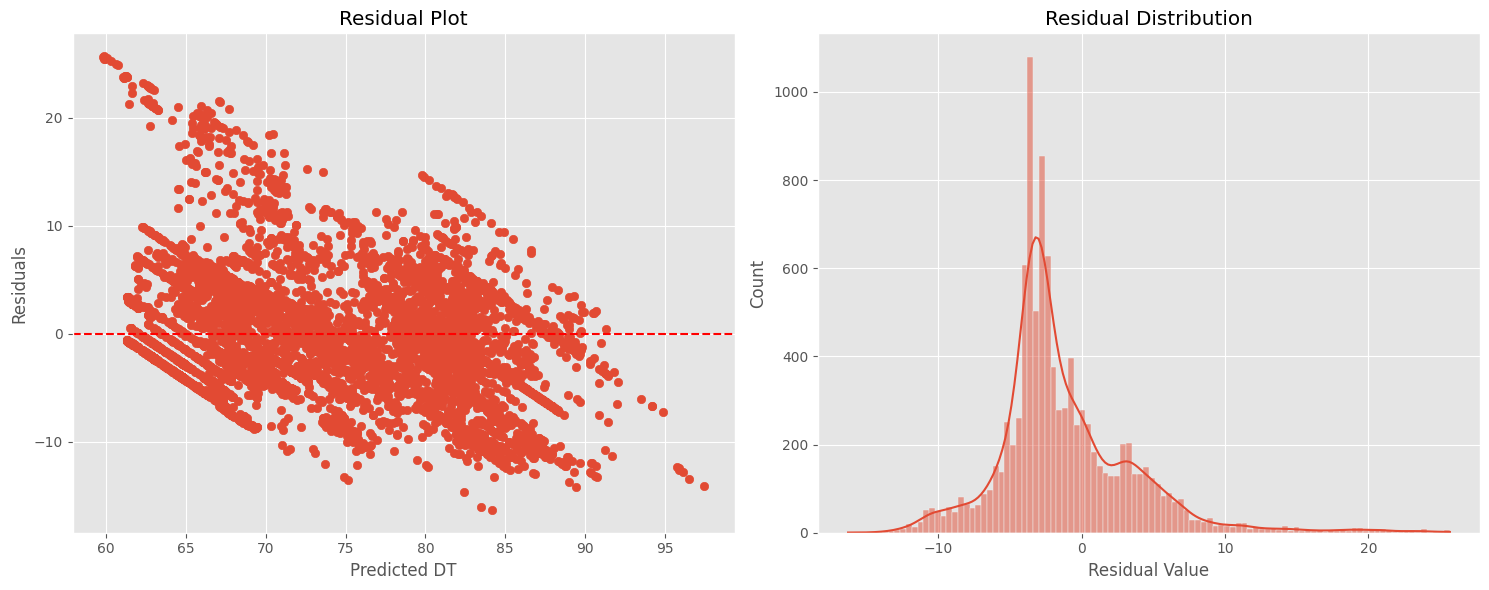

In [13]:
plt.figure(figsize=(15, 6))

# Calculate residuals
residuals = y_test - best_predictions

# Residual plot
plt.subplot(1, 2, 1)
plt.scatter(best_predictions, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted DT')
plt.ylabel('Residuals')
plt.title('Residual Plot')

# Histogram of residuals
plt.subplot(1, 2, 2)
sns.histplot(residuals, kde=True)
plt.xlabel('Residual Value')
plt.title('Residual Distribution')

plt.tight_layout()
plt.savefig('residual_analysis.png')

## Final Model Saving

In [14]:
print("\n--- Model Saving and Final Pipeline ---")

final_pipeline = Pipeline([
    ('scaler', RobustScaler()),
    ('model', best_model)
])

final_pipeline.fit(X, y)

joblib.dump(final_pipeline, 'volve_dt_prediction_model.pkl')
print("Final model pipeline created and ready for deployment")

if best_model_name in ['Random Forest', 'XGBoost']:
    print("\nFeature Importance Summary:")
    for feature, importance in zip(X.columns, best_model.feature_importances_):
        print(f"{feature}: {importance:.4f}")


--- Model Saving and Final Pipeline ---
Final model pipeline created and ready for deployment

Feature Importance Summary:
NPHI: 0.4092
RHOB: 0.0375
GR: 0.0840
RT: 0.0199
PEF: 0.0195
CALI: 0.0416
NPHI_RHOB: 0.2037
GR_NPHI: 0.1372
PEF_RHOB: 0.0290
RT_LOG: 0.0183
